In [11]:
import gpxpy
import gpxpy.gpx
import numpy as np
import haversine as hs


import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [79]:
file_path = 'some-gpx/alpes-8.gpx'
with open(file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

#* Get the number of data points (number of times geolocation was taken):
gpx.get_track_points_no()

395

In [80]:
# Get the number of meters of uphil and downhil ride
# It's a roundtrip, so the numbers are almost identical
gpx.get_uphill_downhill()

UphillDownhill(uphill=2240.5330999999996, downhill=1292.2041000000002)

In [81]:
gpx.tracks[0]

GPXTrack(name='ALPES 8', segments=[GPXTrackSegment(points=[...])])

In [82]:
gpx.tracks[0].segments[0].points[:10]

[GPXTrackPoint(46.363803, 10.895592, elevation=764.931, time=datetime.datetime(2014, 9, 18, 6, 23, 32, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.363687, 10.895473, elevation=805.761, time=datetime.datetime(2014, 9, 18, 6, 24, 14, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.363725, 10.895574, elevation=824.007, time=datetime.datetime(2014, 9, 18, 6, 25, 37, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.364231, 10.895524, elevation=825.407, time=datetime.datetime(2014, 9, 18, 6, 26, 41, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.365102, 10.894322, elevation=831.75, time=datetime.datetime(2014, 9, 18, 6, 28, 2, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.365479, 10.891955, elevation=840.311, time=datetime.datetime(2014, 9, 18, 6, 29, 49, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.366617, 10.889439, elevation=849.921, time=datetime.datetime(2014, 9, 18, 6, 31, 38, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.366933, 10.887685, elevation=860.542, time=datetime.datetime(2014, 9, 18, 6, 33, 32, tzinfo=Sim

In [83]:
route_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation
            })
route_info[:3]

[{'latitude': 46.363803, 'longitude': 10.895592, 'elevation': 764.931},
 {'latitude': 46.363687, 'longitude': 10.895473, 'elevation': 805.761},
 {'latitude': 46.363725, 'longitude': 10.895574, 'elevation': 824.007}]

In [7]:
route_df = pd.DataFrame(route_info)
route_df.head()

,latitude,longitude,elevation
0,46.363803,10.895592,764.931
1,46.363687,10.895473,805.761
2,46.363725,10.895574,824.007
3,46.364231,10.895524,825.407
4,46.365102,10.894322,831.750


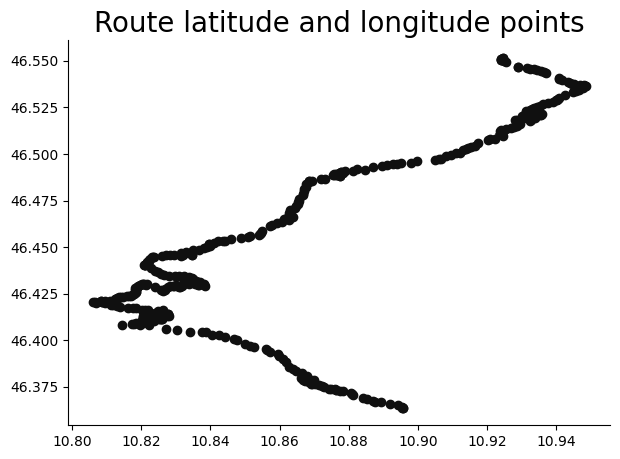

In [8]:
plt.figure(figsize=(7, 5))
plt.scatter(route_df['longitude'], route_df['latitude'], color='#101010')
plt.title('Route latitude and longitude points', size=20);

##### 3- Calculate elevation difference 

In [14]:
route_df['elevation_diff'] = route_df['elevation'].diff()

route_df.head()

,latitude,longitude,elevation,elevation_diff
0,46.363803,10.895592,764.931,NaN
1,46.363687,10.895473,805.761,40.830
2,46.363725,10.895574,824.007,18.246
3,46.364231,10.895524,825.407,1.400
4,46.365102,10.894322,831.750,6.343


In [15]:
def haversine_distance(lat1, lon1, lat2, lon2) -> float:
    distance = hs.haversine(
        point1=(lat1, lon1),
        point2=(lat2, lon2),
        unit=hs.Unit.METERS
    )
    return np.round(distance, 2)

Calculate the distances between all data points

In [17]:
haversine_distance(
    lat1=route_df.iloc[0]['latitude'],
    lon1=route_df.iloc[0]['longitude'],
    lat2=route_df.iloc[1]['latitude'],
    lon2=route_df.iloc[1]['longitude']
)

distances = [np.nan]

for i in range(len(route_df)):
    if i == 0:
        continue
    else:
        distances.append(haversine_distance(
            lat1=route_df.iloc[i - 1]['latitude'],
            lon1=route_df.iloc[i - 1]['longitude'],
            lat2=route_df.iloc[i]['latitude'],
            lon2=route_df.iloc[i]['longitude']
        ))
        
route_df['distance'] = distances
route_df.head()


,latitude,longitude,elevation,elevation_diff,distance
0,46.363803,10.895592,764.931,NaN,NaN
1,46.363687,10.895473,805.761,40.830,15.80
2,46.363725,10.895574,824.007,18.246,8.83
3,46.364231,10.895524,825.407,1.400,56.40
4,46.365102,10.894322,831.750,6.343,133.74


In [75]:
print('Max altitude:', (route_df['elevation']).max(), 'm')
# print('v', route_df[route_df['elevation_diff'] <= 0]['elevation_diff'].sum())

print('Total distance:', route_df['distance'].sum() / 1000 , 'km')

Max altitude: 2466.407 m
Total distance: 42.891569999999994 km


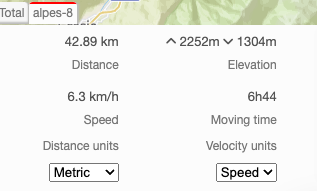

##### Visualize the Elevation profile

In [78]:
route_df['cum_elevation'] = route_df['elevation_diff'].cumsum()
route_df['cum_distance'] = route_df['distance'].cumsum()

route_df = route_df.fillna(0) # replace NANs with zero
route_df.head()

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance
0,46.363803,10.895592,764.931,0.000,0.00,0.000,0.00
1,46.363687,10.895473,805.761,40.830,15.80,40.830,15.80
2,46.363725,10.895574,824.007,18.246,8.83,59.076,24.63
3,46.364231,10.895524,825.407,1.400,56.40,60.476,81.03
4,46.365102,10.894322,831.750,6.343,133.74,66.819,214.77


In [89]:
route_df.to_csv(file_path[:-4] + '-new.csv', index=False) # save the new df to csv

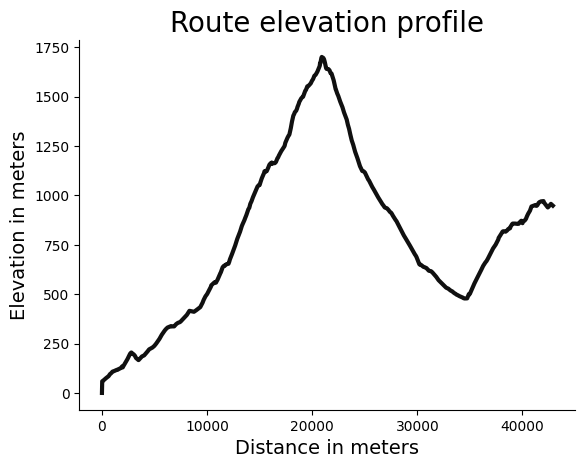

In [97]:
plt.plot(route_df['cum_distance'], route_df['cum_elevation'], color='#101010', lw=3)
plt.title('Route elevation profile', size=20)
plt.xlabel('Distance in meters', size=14)
plt.ylabel('Elevation in meters', size=14);
# plt.savefig('fig.jpg', dpi=300, bbox_inches='tight')